In [1]:
#import all libraries 
import pandas as pd
import numpy as np
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# read the dataset using the compression zip
df_006 = pd.read_csv('data/corona_tested_individuals_ver_006.english.csv.zip',compression='zip', low_memory=False)
df_006.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


In [3]:
df_0083 = pd.read_csv('data/corona_tested_individuals_ver_0083.english.csv', low_memory=False)
df_0083.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-11-12,0,0,0,0,0,negative,No,male,Other
1,2020-11-12,0,1,0,0,0,negative,No,male,Other
2,2020-11-12,0,0,0,0,0,negative,Yes,female,Other
3,2020-11-12,0,0,0,0,0,negative,No,male,Other
4,2020-11-12,0,1,0,0,0,negative,No,male,Contact with confirmed


In [4]:
df_006.dtypes

test_date              object
cough                  object
fever                  object
sore_throat            object
shortness_of_breath    object
head_ache              object
corona_result          object
age_60_and_above       object
gender                 object
test_indication        object
dtype: object

In [5]:
df_006.info

<bound method DataFrame.info of          test_date cough fever sore_throat shortness_of_breath head_ache  \
0       2020-04-30     0     0           0                   0         0   
1       2020-04-30     1     0           0                   0         0   
2       2020-04-30     0     1           0                   0         0   
3       2020-04-30     1     0           0                   0         0   
4       2020-04-30     1     0           0                   0         0   
...            ...   ...   ...         ...                 ...       ...   
278843  2020-03-11     0     0           0                   0         0   
278844  2020-03-11     0     0           0                   0         0   
278845  2020-03-11     0     0           0                   0         0   
278846  2020-03-11     0     0           0                   0         0   
278847  2020-03-11     0     0           0                   0         0   

       corona_result age_60_and_above  gender         t

In [6]:
df_006['gender'].value_counts()

female    130158
male      129127
None       19563
Name: gender, dtype: int64

In [7]:
df_006_total = df_006.loc[(df_006['test_date'] >= '2020-03-22')  &  (df_006['test_date'] <= '2020-04-7')]
print(df_006_total.size)
print(df_006.size)
df_006_total['gender'].value_counts()

2651210
2788480


female    130158
male      129127
None        5836
Name: gender, dtype: int64

In [8]:
df_006_train_val = df_006.loc[(df_006['test_date'] >= '2020-03-22') & (df_006['test_date'] <= '2020-03-31')]
df_006_train_val.info

<bound method DataFrame.info of          test_date cough fever sore_throat shortness_of_breath head_ache  \
211278  2020-03-31     0     0           0                   0         0   
211279  2020-03-31     0     0           0                   0         0   
211280  2020-03-31     0     0           0                   0         0   
211281  2020-03-31     0     0           0                   0         0   
211282  2020-03-31     1     0           0                   0         0   
...            ...   ...   ...         ...                 ...       ...   
265116  2020-03-22     1     1           0                   0         0   
265117  2020-03-22     1     1           1                   0         1   
265118  2020-03-22     1     0           0                   0         0   
265119  2020-03-22     1     0           0                   0         0   
265120  2020-03-22     1     0           0                   0         0   

       corona_result age_60_and_above  gender test_indi

In [9]:
df_006_train_val['gender'].value_counts()

female    26436
male      26213
None       1194
Name: gender, dtype: int64

In [10]:
nan_in_data = df_006.isna().sum().any()
nan_in_data

False

In [11]:
from copy import deepcopy
df = deepcopy(df_006)

In [12]:
df.columns


Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication'],
      dtype='object')

In [13]:
pd.unique(df['cough'])


array(['0', '1', 'None'], dtype=object)

In [14]:

def clean_num_columns(data, num_columns):   
    for i in num_columns:
        data = data[data[i] != 'None']   
    data[num_columns] = data[num_columns].apply(pd.to_numeric)
    for i in num_columns:
        print (pd.unique(data[i]))
    return data

In [15]:
num_columns = ['cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache']
df = clean_num_columns(df, num_columns)

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [16]:
df['cough'].value_counts()

0    236368
1     42226
Name: cough, dtype: int64

In [17]:
cat_columns = ['corona_result', 'age_60_and_above', 'gender',
       'test_indication']

In [18]:
def clean_cat_columns(dataframe, cat_columns):
    for i in cat_columns:
        dataframe = dataframe[dataframe[i] != 'None']
        print (pd.unique(dataframe[i]))
    return dataframe
    

In [19]:
df = clean_cat_columns(df, cat_columns)

['negative' 'positive' 'other']
['Yes' 'No']
['male' 'female']
['Other' 'Abroad' 'Contact with confirmed']


In [20]:
df = df[df['corona_result'] != 'other']
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
122808,2020-04-14,1,0,0,0,0,negative,Yes,male,Other
122809,2020-04-14,1,0,0,0,0,positive,No,female,Other
122810,2020-04-14,0,0,0,0,0,negative,No,female,Other
122811,2020-04-14,0,1,0,0,0,negative,No,female,Abroad
122812,2020-04-14,1,0,0,0,0,negative,Yes,female,Other


In [21]:
df['age_60_and_above'] = df['age_60_and_above'].map({"Yes":1, "No" : 0})
df['gender'] = df['gender'].map({"male":1, "female" : 0})
df['test_indication'] = df['test_indication'].map({"Contact with confirmed":1, "Other" : 0, "Abroad" : 0})
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
122808,2020-04-14,1,0,0,0,0,negative,1,1,0
122809,2020-04-14,1,0,0,0,0,positive,0,0,0
122810,2020-04-14,0,0,0,0,0,negative,0,0,0
122811,2020-04-14,0,1,0,0,0,negative,0,0,0
122812,2020-04-14,1,0,0,0,0,negative,1,0,0


In [22]:
df['corona_result'] = df['corona_result'].map({"negative":0, "positive":1})
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
122808,2020-04-14,1,0,0,0,0,0,1,1,0
122809,2020-04-14,1,0,0,0,0,1,0,0,0
122810,2020-04-14,0,0,0,0,0,0,0,0,0
122811,2020-04-14,0,1,0,0,0,0,0,0,0
122812,2020-04-14,1,0,0,0,0,0,1,0,0


In [23]:
df_006_train_val = df.loc[(df['test_date'] >= '2020-03-22') & (df['test_date'] <= '2020-03-31')]
df_006_train_val.info

<bound method DataFrame.info of          test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
211278  2020-03-31      0      0            0                    0          0   
211279  2020-03-31      0      0            0                    0          0   
211280  2020-03-31      0      0            0                    0          0   
211281  2020-03-31      0      0            0                    0          0   
211282  2020-03-31      1      0            0                    0          0   
...            ...    ...    ...          ...                  ...        ...   
265116  2020-03-22      1      1            0                    0          0   
265117  2020-03-22      1      1            1                    0          1   
265118  2020-03-22      1      0            0                    0          0   
265119  2020-03-22      1      0            0                    0          0   
265120  2020-03-22      1      0            0                    0          0

In [24]:
df_006_train_val['corona_result'].value_counts()

0    47054
1     4760
Name: corona_result, dtype: int64

In [25]:
for i in df_006_train_val.columns:
    print (pd.unique(df_006_train_val[i]))

['2020-03-31' '2020-03-30' '2020-03-29' '2020-03-28' '2020-03-27'
 '2020-03-26' '2020-03-25' '2020-03-24' '2020-03-23' '2020-03-22']
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]


In [26]:
df_006_train_val.drop(['test_date'], axis=1, inplace=True)

c:\python3.7.3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
df_006_train_val.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
211278,0,0,0,0,0,0,0,1,0
211279,0,0,0,0,0,0,0,0,0
211280,0,0,0,0,0,0,0,1,0
211281,0,0,0,0,0,1,0,0,0
211282,1,0,0,0,0,0,0,1,0


In [28]:
'''def train_lgbm(X_train, X_test, y_train, y_test, categorical_features):
    
    categorical_encoder = OneHotEncoder(handle_unknown='ignore')
    
    """numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])"""

    preprocessing = ColumnTransformer(
        [('cat', categorical_encoder, categorical_features)])

    lgbm = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', LGBMClassifier(class_weight="balanced", n_jobs=-1))
    ])

    lgbm.fit(X_train, y_train)
    
    print("LightGBM train accuracy: %0.3f" % lgbm.score(X_train, y_train))
    print("LightGBM test accuracy: %0.3f" % lgbm.score(X_test, y_test))
    print("LightGBM balanced test accuracy: %0.3f" % balanced_accuracy_score(y_test, lgbm.predict(X_test)))
    
    return lgbm'''

'def train_lgbm(X_train, X_test, y_train, y_test, categorical_features):\n    \n    categorical_encoder = OneHotEncoder(handle_unknown=\'ignore\')\n    \n    """numerical_pipe = Pipeline([\n        (\'imputer\', SimpleImputer(strategy=\'mean\'))\n    ])"""\n\n    preprocessing = ColumnTransformer(\n        [(\'cat\', categorical_encoder, categorical_features)])\n\n    lgbm = Pipeline([\n        (\'preprocess\', preprocessing),\n        (\'classifier\', LGBMClassifier(class_weight="balanced", n_jobs=-1))\n    ])\n\n    lgbm.fit(X_train, y_train)\n    \n    print("LightGBM train accuracy: %0.3f" % lgbm.score(X_train, y_train))\n    print("LightGBM test accuracy: %0.3f" % lgbm.score(X_test, y_test))\n    print("LightGBM balanced test accuracy: %0.3f" % balanced_accuracy_score(y_test, lgbm.predict(X_test)))\n    \n    return lgbm'

In [29]:
#y = df_006_train_val["corona_result"]
#y = y.map({"negative":0, "positive" : 1})
#y

In [30]:
df_006_train_val.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'corona_result', 'age_60_and_above', 'gender', 'test_indication'],
      dtype='object')

In [31]:
X = df_006_train_val.drop(['corona_result'], axis = 1)
categorical_features = X.columns
categorical_features

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age_60_and_above', 'gender', 'test_indication'],
      dtype='object')

In [32]:
X = df_006_train_val.drop(['corona_result'], axis = 1)
y = df_006_train_val["corona_result"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

In [33]:
def train_model(X_train, X_val, y_train, y_val):
    
    # train a LightGBM model
    model = LGBMClassifier(num_leaves= 20,
                            min_data_in_leaf= 4,
                            feature_fraction= 0.2,
                            bagging_fraction= 0.8,
                            bagging_freq= 5,
                            learning_rate= 0.05,
                            verbose= 1,
                            num_boost_round=603,
                            
                          )

    model.fit(X_train, y_train)

    # compute test accuracy
    print("LightGBM test accuracy: %0.3f" % model.score(X_val, y_val))
    return model

In [34]:
#lgbm = train_lgbm(X_train, X_test, y_train, y_test, categorical_features)
lgbm = train_model(X_train, X_val, y_train, y_val)

c:\python3.7.3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] num_iterations is set=603, num_boost_round=603 will be ignored. Current value: num_iterations=603
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsamp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM test accuracy: 0.956


In [35]:
from sklearn.metrics import PrecisionRecallDisplay
def evaluate(X_test, y_test, model, model_name = 'label', plot_colour = 'C2' ):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc= auc(fpr, tpr)
    print("AUC score: ", roc_auc)
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color=plot_colour,
             lw=lw, label=model_name+'-AUC:' + str(roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, ls='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.grid(visible=True)
    plt.xlabel('1-specificity', fontsize=12)
    plt.ylabel('Sensitivity', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()
    
    display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, )
    _ = display.ax_.set_title("Precision-Recall curve")

AUC score:  0.934954826702608


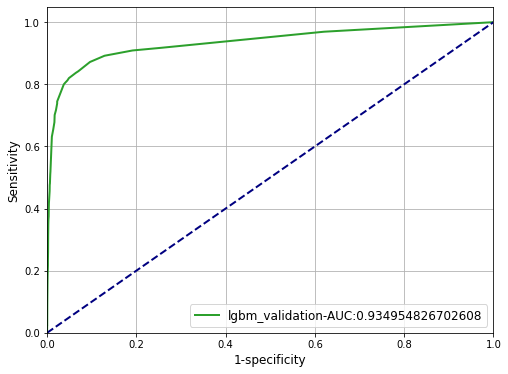

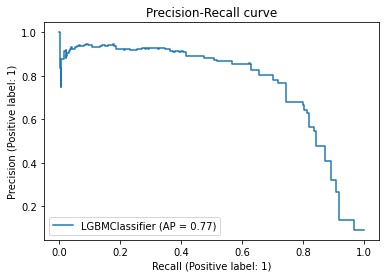

In [36]:

evaluate(X_val, y_val, lgbm, 'lgbm_validation', 'C2')

In [37]:
df_006_test = df.loc[(df['test_date'] >= '2020-04-01') & (df['test_date'] <= '2020-04-07')]
df_006_test.drop(['test_date'], axis=1, inplace=True)
df_006_test.info

c:\python3.7.3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<bound method DataFrame.info of         cough  fever  sore_throat  shortness_of_breath  head_ache  \
162404      0      0            0                    0          0   
162405      0      0            0                    0          0   
162406      0      0            0                    0          0   
162407      0      0            0                    0          0   
162408      0      0            0                    0          0   
...       ...    ...          ...                  ...        ...   
211273      0      0            0                    0          1   
211274      0      0            0                    0          0   
211275      1      0            1                    0          0   
211276      1      0            1                    0          0   
211277      1      0            0                    0          0   

        corona_result  age_60_and_above  gender  test_indication  
162404              0                 0       1                0  
16240

In [38]:
X_test = df_006_test.drop(['corona_result'], axis = 1)
X_test

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
162404,0,0,0,0,0,0,1,0
162405,0,0,0,0,0,1,0,0
162406,0,0,0,0,0,1,1,0
162407,0,0,0,0,0,0,1,0
162408,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
211273,0,0,0,0,1,0,0,0
211274,0,0,0,0,0,0,0,0
211275,1,0,1,0,0,0,0,0
211276,1,0,1,0,0,0,1,0


In [39]:
df_006_test.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
162404,0,0,0,0,0,0,0,1,0
162405,0,0,0,0,0,0,1,0,0
162406,0,0,0,0,0,0,1,1,0
162407,0,0,0,0,0,0,0,1,0
162408,0,0,0,0,0,0,0,0,0


In [40]:
y_test = df_006_test["corona_result"]
y_test

162404    0
162405    0
162406    0
162407    0
162408    0
         ..
211273    0
211274    0
211275    0
211276    0
211277    0
Name: corona_result, Length: 47175, dtype: int64

AUC score:  0.9041291501838195


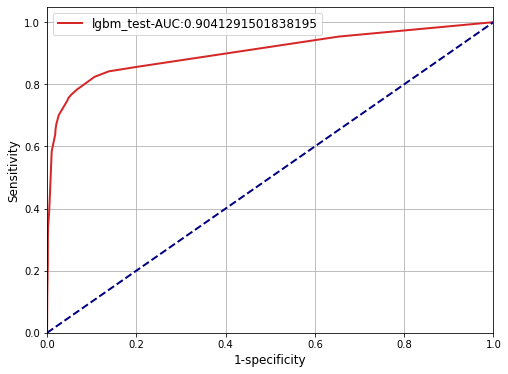

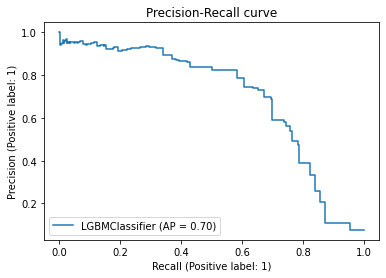

In [41]:
evaluate(X_test, y_test, lgbm, 'lgbm_test', 'C3')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


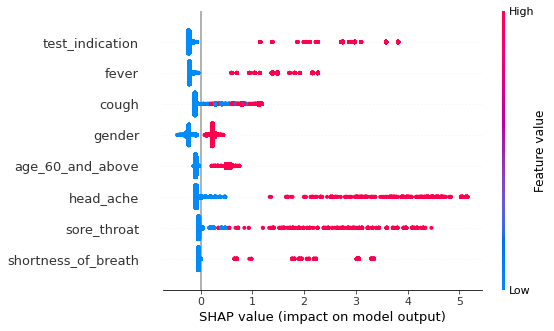

In [42]:
import shap
shap.initjs() # need to load JS vis in the notebook for shap to display
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [43]:
print(classification_report(y_test, lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     43570
           1       0.82      0.58      0.68      3605

    accuracy                           0.96     47175
   macro avg       0.89      0.78      0.83     47175
weighted avg       0.96      0.96      0.95     47175



<AxesSubplot:>

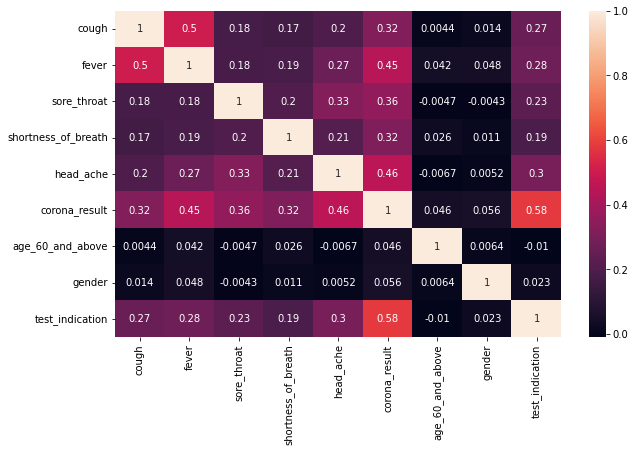

In [44]:
import seaborn as sns
cor = df_006_train_val.corr()
plt.figure(figsize = (10, 6))
sns.heatmap(cor, annot = True)

In [45]:
df_reduced = df_006.drop(['age_60_and_above', 'gender'], axis=1)
df_reduced.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,test_indication
0,2020-04-30,0,0,0,0,0,negative,Other
1,2020-04-30,1,0,0,0,0,negative,Other
2,2020-04-30,0,1,0,0,0,negative,Other
3,2020-04-30,1,0,0,0,0,negative,Other
4,2020-04-30,1,0,0,0,0,negative,Other


In [46]:
num_columns

['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']

In [47]:
df_reduced = clean_num_columns(df_reduced, num_columns)

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [48]:
df_reduced['cough'].value_counts()

0    236368
1     42226
Name: cough, dtype: int64

In [49]:
cat_columns = ['test_indication']
df_reduced = clean_cat_columns(df_reduced, cat_columns)

['Other' 'Abroad' 'Contact with confirmed']


In [50]:
df_reduced = df_reduced[df_reduced['corona_result'] != 'other']
df_reduced['test_indication'] = df_reduced['test_indication'].map({"Contact with confirmed":1, "Other" : 0, "Abroad" : 0})
df_reduced['corona_result'] = df_reduced['corona_result'].map({"negative":0, "positive":1})
df_reduced.value_counts()

test_date   cough  fever  sore_throat  shortness_of_breath  head_ache  corona_result  test_indication
2020-04-20  0      0      0            0                    0          0              0                  9397
2020-04-19  0      0      0            0                    0          0              0                  8303
2020-04-21  0      0      0            0                    0          0              0                  8229
2020-04-22  0      0      0            0                    0          0              0                  8013
2020-04-01  0      0      0            0                    0          0              0                  7606
                                                                                                         ... 
2020-04-06  1      0      0            1                    0          0              0                     1
                                                                       1              1                     1
                  

In [51]:
df_reduced_train_val = df_reduced.loc[(df_reduced['test_date'] >= '2020-03-22') & (df_reduced['test_date'] <= '2020-03-31')]
df_reduced_test = df_reduced.loc[(df_reduced['test_date'] >= '2020-04-01') & (df_reduced['test_date'] <= '2020-04-07')]
df_reduced_train_val.drop(['test_date'], axis=1, inplace=True)
df_reduced_test.drop(['test_date'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
df_reduced_train_val.value_counts()

cough  fever  sore_throat  shortness_of_breath  head_ache  corona_result  test_indication
0      0      0            0                    0          0              0                  42135
1      0      0            0                    0          0              0                   3158
       1      0            0                    0          0              0                   1783
0      0      0            0                    0          1              1                    548
                                                                          0                    523
                                                                                             ...  
       1      1            1                    1          1              1                      1
              0            1                    0          0              1                      1
       0      0            0                    1          0              0                      1
              1    

In [53]:
df_reduced_test.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,test_indication
162404,0,0,0,0,0,0,0
162405,0,0,0,0,0,0,0
162406,0,0,0,0,0,0,0
162407,0,0,0,0,0,0,0
162408,0,0,0,0,0,0,0


In [54]:
X_reduced = df_reduced_train_val.drop(['corona_result'], axis = 1)
y_reduced = df_reduced_train_val["corona_result"]
X_test_reduced = df_reduced_test.drop(['corona_result'], axis = 1)
y_test_reduced = df_reduced_test["corona_result"]
X_train_reduced, X_val_reduced, y_train_reduced, y_val_reduced = train_test_split(X_reduced, y_reduced, test_size = 0.2)

In [55]:
y_val_reduced.isnull().values.any()

False

In [56]:

lgbm_reduced = train_model(X_train_reduced, X_val_reduced, y_train_reduced, y_val_reduced)


Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] num_iterations is set=603, num_boost_round=603 will be ignored. Current value: num_iterations=603
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsamp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

AUC score:  0.9229270806157615


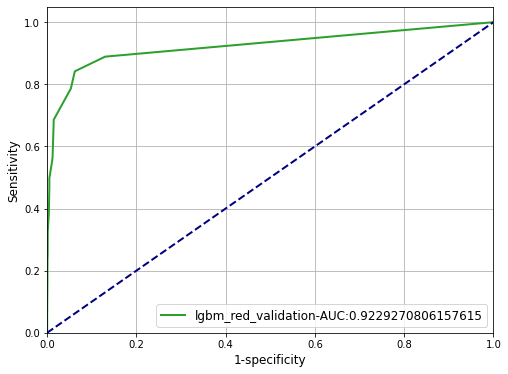

AUC score:  0.8915559311299176


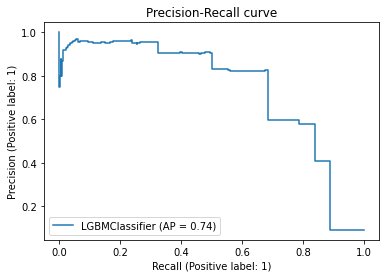

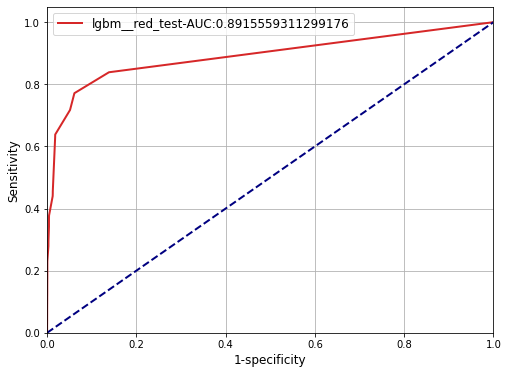

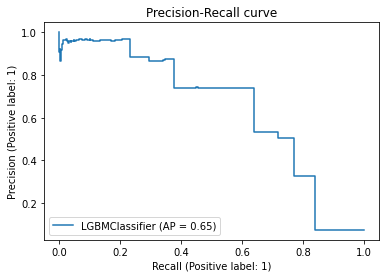

In [57]:
evaluate(X_val_reduced, y_val_reduced, lgbm_reduced, 'lgbm_red_validation', 'C2')
evaluate(X_test_reduced, y_test_reduced, lgbm_reduced, 'lgbm__red_test', 'C3')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


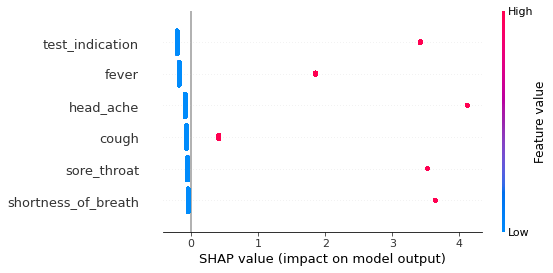

In [58]:
explainer = shap.TreeExplainer(lgbm_reduced)
shap_values = explainer.shap_values(X_test_reduced)
shap.summary_plot(shap_values[1], X_test_reduced)

In [59]:
print(classification_report(y_test_reduced, lgbm_reduced.predict(X_test_reduced)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     44614
           1       0.74      0.45      0.56      3622

    accuracy                           0.95     48236
   macro avg       0.85      0.72      0.77     48236
weighted avg       0.94      0.95      0.94     48236

